# Exoplanet Detection with AI/ML

This notebook implements machine learning models to detect exoplanets from NASA's cleaned exoplanet survey data.

## Dataset
- **File**: `data_with_merged_errors.csv` (1,782 samples, 29 features)
- **Target**: `tfopwg_disp` (0=Not Exoplanet, 1=Exoplanet)
- **Features**: 28 exoplanet-related features (orbital period, transit depth, stellar properties, etc.)

## Models
- XGBoost

## Data Processing
- **Normalization**: StandardScaler applied to all features

## Data Split
- 60% Training
- 20% Validation
- 20% Testing

## 1. Import Libraries and Setup


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Data Loading and Exploration


In [7]:
# Load the cleaned dataset
data_path = 'data_with_merged_errors.csv'

try:
    df = pd.read_csv(data_path)
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Target column 'tfopwg_disp' distribution:")
    print(df['tfopwg_disp'].value_counts())
    print(f"Target column proportions:")
    print(df['tfopwg_disp'].value_counts(normalize=True))
except FileNotFoundError:
    print("Error: cleaned_data.csv not found. Please ensure the file is in the same directory as this notebook.")


Dataset loaded successfully!
Shape: (1782, 29)
Columns: ['tfopwg_disp', 'ra', 'dec', 'st_pmra', 'st_pmdec', 'pl_tranmid', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad', 'st_pmra_err', 'st_pmdec_err', 'pl_tranmid_err', 'pl_orbper_err', 'pl_trandurh_err', 'pl_trandep_err', 'pl_rade_err', 'st_tmag_err', 'st_dist_err', 'st_teff_err', 'st_logg_err', 'st_rad_err']
Target column 'tfopwg_disp' distribution:
tfopwg_disp
1    970
0    812
Name: count, dtype: int64
Target column proportions:
tfopwg_disp
1    0.544332
0    0.455668
Name: proportion, dtype: float64


In [9]:
# Display basic information about the dataset
print("Dataset Info:")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"\nColumn types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nFirst few rows:")
df.head()


Dataset Info:
Shape: (1782, 29)

Column types:
tfopwg_disp          int64
ra                 float64
dec                float64
st_pmra            float64
st_pmdec           float64
pl_tranmid         float64
pl_orbper          float64
pl_trandurh        float64
pl_trandep         float64
pl_rade            float64
pl_insol           float64
pl_eqt             float64
st_tmag            float64
st_dist            float64
st_teff            float64
st_logg            float64
st_rad             float64
st_pmra_err        float64
st_pmdec_err       float64
pl_tranmid_err     float64
pl_orbper_err      float64
pl_trandurh_err    float64
pl_trandep_err     float64
pl_rade_err        float64
st_tmag_err        float64
st_dist_err        float64
st_teff_err        float64
st_logg_err        float64
st_rad_err         float64
dtype: object

Missing values:
tfopwg_disp        0
ra                 0
dec                0
st_pmra            0
st_pmdec           0
pl_tranmid         0
pl_orbper    

,tfopwg_disp,ra,dec,st_pmra,st_pmdec,pl_tranmid,pl_orbper,pl_trandurh,pl_trandep,pl_rade,...,pl_tranmid_err,pl_orbper_err,pl_trandurh_err,pl_trandep_err,pl_rade_err,st_tmag_err,st_dist_err,st_teff_err,st_logg_err,st_rad_err
0,0,112.357708,-12.695960,-5.964,-0.076,2.459230e+06,2.171348,2.01722,656.886099,5.818163,...,0.001657,0.000264,0.319588,37.77821,1.910546,0.013,11.9515,264.7,0.07,0.072573
1,0,122.178195,-48.802811,-4.496,9.347,2.459987e+06,3.573014,3.37000,755.000000,11.311300,...,0.003748,0.000013,1.029000,1306.55000,3.247140,0.006,4.6175,171.1,0.07,0.060000
2,0,116.110771,-36.098285,-9.231,11.614,2.459239e+06,12.688942,7.92010,3232.852788,14.060834,...,0.006715,0.009509,0.539377,235.25328,15.241591,0.006,3.7840,135.8,0.08,0.047980
3,0,124.726411,-37.783250,-11.278,9.593,2.458519e+06,1.104220,2.37000,14177.700000,21.044800,...,0.001370,0.000130,0.062000,843.78800,5.220120,0.006,4.7245,157.0,0.55,0.070000
4,0,111.716019,-50.266567,-8.018,11.560,2.458493e+06,4.959120,2.50900,7440.000000,22.912300,...,0.000730,0.000160,0.130000,197.96200,3.280550,0.006,2.9645,124.3,0.07,0.090000


Target variable distribution:
tfopwg_disp
1    970
0    812
Name: count, dtype: int64

Proportions:
tfopwg_disp
1    0.544332
0    0.455668
Name: proportion, dtype: float64


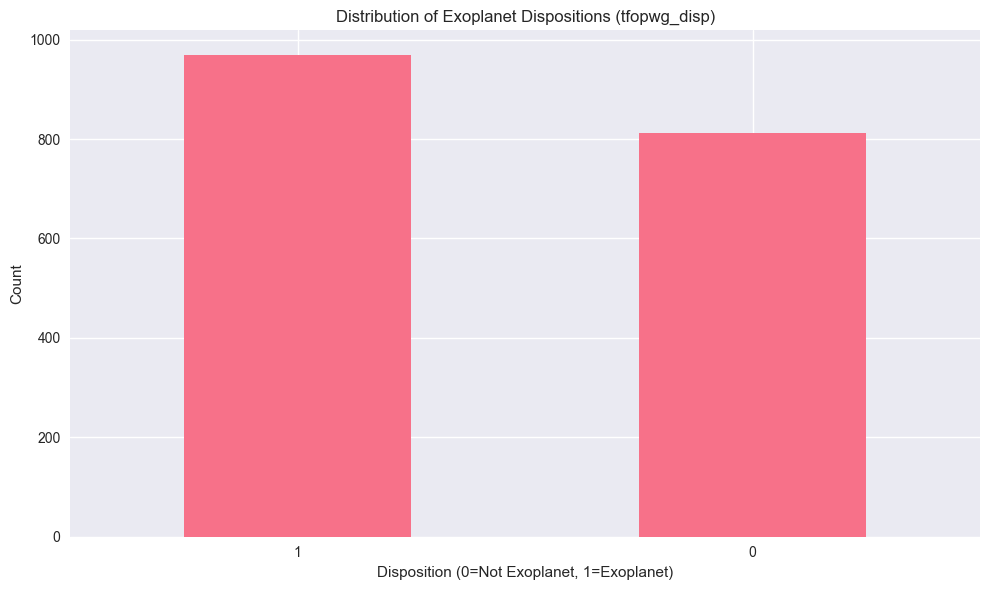

In [11]:
# Check target variable distribution
if 'tfopwg_disp' in df.columns:
    print("Target variable distribution:")
    print(df['tfopwg_disp'].value_counts())
    print(f"\nProportions:")
    print(df['tfopwg_disp'].value_counts(normalize=True))
    
    # Visualize target distribution
    plt.figure(figsize=(10, 6))
    df['tfopwg_disp'].value_counts().plot(kind='bar')
    plt.title('Distribution of Exoplanet Dispositions (tfopwg_disp)')
    plt.xlabel('Disposition (0=Not Exoplanet, 1=Exoplanet)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Target variable 'tfopwg_disp' not found in the dataset.")
    print("Available columns:", list(df.columns))


## 3. Data Preparation with Normalization
 

In [14]:
# Prepare data with normalization
df_processed = df.copy()

print("Preparing data with normalization...")
print(f"Dataset shape: {df_processed.shape}")
print(f"Missing values: {df_processed.isnull().sum().sum()}")
print(f"Columns: {list(df_processed.columns)}")

# Handle any remaining missing values
if df_processed.isnull().sum().sum() > 0:
    print("Handling missing values...")
    df_processed = df_processed.fillna(df_processed.median())
    print(f"Missing values after filling: {df_processed.isnull().sum().sum()}")


Preparing data with normalization...
Dataset shape: (1782, 29)
Missing values: 0
Columns: ['tfopwg_disp', 'ra', 'dec', 'st_pmra', 'st_pmdec', 'pl_tranmid', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad', 'st_pmra_err', 'st_pmdec_err', 'pl_tranmid_err', 'pl_orbper_err', 'pl_trandurh_err', 'pl_trandep_err', 'pl_rade_err', 'st_tmag_err', 'st_dist_err', 'st_teff_err', 'st_logg_err', 'st_rad_err']


In [16]:
# Prepare features and target
if 'tfopwg_disp' in df_processed.columns:
    # Use tfopwg_disp as target: 1 for exoplanets, 0 for non-exoplanets
    y = df_processed['tfopwg_disp']
    
    # Remove the target column from features
    X = df_processed.drop(columns=['tfopwg_disp'])
    
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Exoplanet ratio: {y.mean():.3f}")
    print(f"Features: {list(X.columns)}")
else:
    print("Target variable 'tfopwg_disp' not found. Please check your dataset.")
    X = df_processed
    y = None

Features shape: (1782, 28)
Target shape: (1782,)
Exoplanet ratio: 0.544
Features: ['ra', 'dec', 'st_pmra', 'st_pmdec', 'pl_tranmid', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad', 'st_pmra_err', 'st_pmdec_err', 'pl_tranmid_err', 'pl_orbper_err', 'pl_trandurh_err', 'pl_trandep_err', 'pl_rade_err', 'st_tmag_err', 'st_dist_err', 'st_teff_err', 'st_logg_err', 'st_rad_err']


In [18]:
# Apply normalization to features
print("Applying StandardScaler normalization...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"Final features shape: {X_scaled.shape}")
print(f"Feature names: {list(X_scaled.columns)}")
print("✅ Features normalized using StandardScaler")

Applying StandardScaler normalization...
Final features shape: (1782, 28)
Feature names: ['ra', 'dec', 'st_pmra', 'st_pmdec', 'pl_tranmid', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad', 'st_pmra_err', 'st_pmdec_err', 'pl_tranmid_err', 'pl_orbper_err', 'pl_trandurh_err', 'pl_trandep_err', 'pl_rade_err', 'st_tmag_err', 'st_dist_err', 'st_teff_err', 'st_logg_err', 'st_rad_err']
✅ Features normalized using StandardScaler


In [20]:
X_scaled

,ra,dec,st_pmra,st_pmdec,pl_tranmid,pl_orbper,pl_trandurh,pl_trandep,pl_rade,pl_insol,...,pl_tranmid_err,pl_orbper_err,pl_trandurh_err,pl_trandep_err,pl_rade_err,st_tmag_err,st_dist_err,st_teff_err,st_logg_err,st_rad_err
0,-0.630249,-0.423809,-0.055604,0.161797,-0.407796,-0.146270,-0.568890,-0.461179,-0.500160,1.434895,...,-0.221013,-0.006639,0.025093,-0.216117,0.231152,0.859296,0.726111,0.305256,-0.320280,0.074907
1,-0.537382,-1.196706,-0.043897,0.256548,0.743908,-0.124256,0.240866,-0.453857,0.278686,3.839159,...,0.321452,-0.283642,2.432406,0.543742,0.782832,-0.218626,-0.059582,0.012141,-0.320280,-0.184883
2,-0.594758,-0.924755,-0.081657,0.279343,-0.393805,0.018917,2.964492,-0.268931,0.668529,-0.227300,...,1.091175,10.200295,0.770922,-0.097851,5.733545,-0.218626,-0.148875,-0.098404,-0.289002,-0.433250
3,-0.513284,-0.960823,-0.097981,0.259021,-1.488410,-0.163030,-0.357720,0.547900,1.658751,2.698389,...,-0.295468,-0.154249,-0.849004,0.266597,1.597180,-0.218626,-0.048119,-0.032014,1.181037,0.021744
4,-0.636317,-1.228039,-0.071984,0.278800,-1.528225,-0.102486,-0.274517,0.045055,1.923535,-0.208683,...,-0.461502,-0.121128,-0.618253,-0.120184,0.796622,-0.218626,-0.236668,-0.134417,-0.320280,0.434998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777,-0.620165,-0.815538,-0.049742,0.201184,-1.529541,-0.112769,0.041537,-0.460051,0.625364,-0.221400,...,0.939409,2.440239,0.331897,-0.237243,0.012301,0.089352,1.329629,0.249827,4.934328,6.427181
1778,-0.604824,-0.346498,-0.065692,0.137604,-0.407386,-0.142731,0.585242,-0.481478,-0.780854,0.904918,...,0.396945,0.471078,1.349619,-0.218501,0.241200,-0.218626,1.495198,0.174043,-0.320280,0.207399
1779,-0.545502,-1.427397,-0.365072,0.136257,-0.407007,-0.048233,0.352702,0.794326,1.583023,-0.249579,...,-0.562679,-0.005756,-0.951167,-0.174201,1.579266,-0.218626,-0.525812,-0.107485,-0.289002,-0.478520
1780,-0.573871,-0.456407,-0.021647,0.145327,-0.407888,-0.165587,-0.961874,-0.484835,-0.682914,2.856034,...,-0.073917,-0.123225,0.253076,-0.218566,1.090264,-0.064637,0.639228,-0.114375,-0.320280,0.467602


## 4. Data Splitting (60% Train, 20% Validation, 20% Test)


In [23]:
# Split the data: 60% train, 20% validation, 20% test
if y is not None:
    # Split normalized data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_scaled, y, test_size=0.4, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
       
    print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
    print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
    print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
    
    print(f"\nTraining set exoplanet ratio: {y_train.mean():.3f}")
    print(f"Validation set exoplanet ratio: {y_val.mean():.3f}")
    print(f"Test set exoplanet ratio: {y_test.mean():.3f}")

Training set: 1069 samples (60.0%)
Validation set: 356 samples (20.0%)
Test set: 357 samples (20.0%)

Training set exoplanet ratio: 0.544
Validation set exoplanet ratio: 0.545
Test set exoplanet ratio: 0.543


## 5. XGBoost Training and Evaluation 


In [26]:
! "C:\Program Files\Python313\python.exe" -m pip install xgboost

try:
    import xgboost as xgb
    print("XGBoost is already installed.")
except ImportError:
    print("Installing XGBoost...")
    !pip install xgboost
    import xgboost as xgb
    print("XGBoost installed successfully.")


Defaulting to user installation because normal site-packages is not writeable
XGBoost is already installed.


Training XGBoost model...
✅ XGBoost - Test AUC: 0.9520

Top 10 Most Important Features:
            feature  importance
10           pl_eqt    0.152941
20  pl_trandurh_err    0.065592
24      st_dist_err    0.060876
12          st_dist    0.054204
7        pl_trandep    0.049855
22      pl_rade_err    0.043310
4        pl_tranmid    0.041718
13          st_teff    0.035803
15           st_rad    0.035007
5         pl_orbper    0.034910


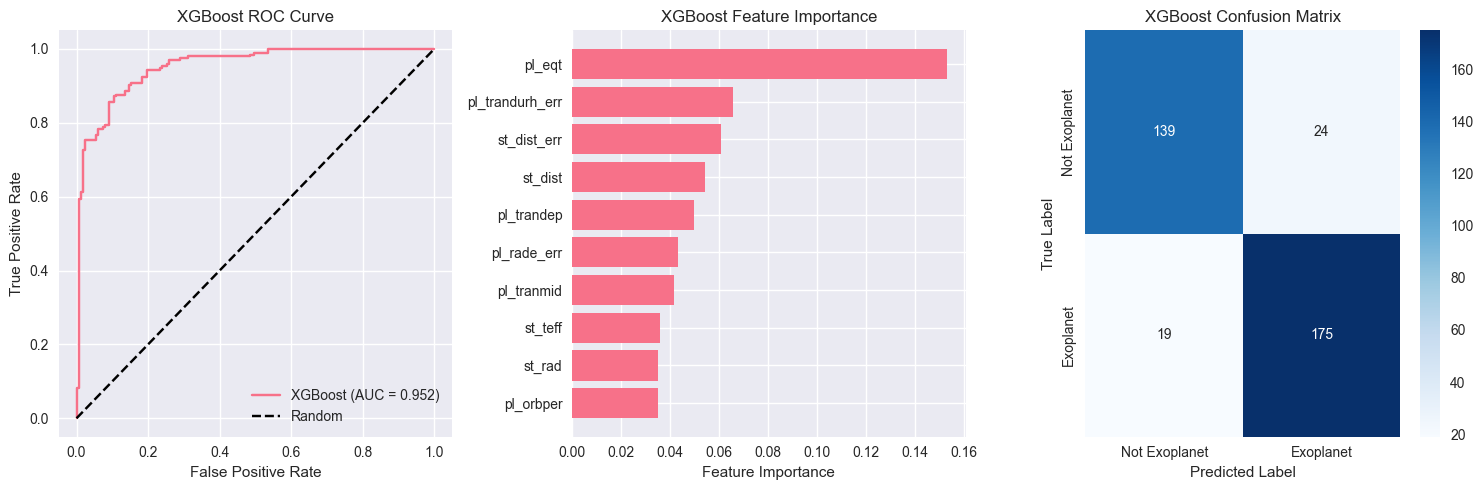

In [28]:
# XGBoost Training
if y is not None:
    print("Training XGBoost model...")
    print("=" * 60)
    
    # XGBoost parameters
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'early_stopping_rounds': 10,
        'random_state': 42
    }
    
    # Create and train XGBoost model
    xgb_model = xgb.XGBClassifier(**xgb_params)
    
    # Train with early stopping
    try:
        xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    except TypeError:
        xgb_params_fallback = xgb_params.copy()
        xgb_params_fallback.pop('early_stopping_rounds', None)
        xgb_model = xgb.XGBClassifier(**xgb_params_fallback)
        xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
    
    # Make predictions
    y_test_pred_xgb = xgb_model.predict(X_test)
    y_test_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    test_auc_xgb = roc_auc_score(y_test, y_test_proba_xgb)
    
    print(f"✅ XGBoost - Test AUC: {test_auc_xgb:.4f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_scaled.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # ROC curve
    plt.subplot(1, 3, 1)
    fpr, tpr, _ = roc_curve(y_test, y_test_proba_xgb)
    plt.plot(fpr, tpr, label=f'XGBoost (AUC = {test_auc_xgb:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('XGBoost ROC Curve')
    plt.legend()
    plt.grid(True)
    
    # Feature importance
    plt.subplot(1, 3, 2)
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('XGBoost Feature Importance')
    plt.gca().invert_yaxis()
    
    # Confusion Matrix
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_test, y_test_pred_xgb)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Exoplanet', 'Exoplanet'],
                yticklabels=['Not Exoplanet', 'Exoplanet'])
    plt.title('XGBoost Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Cannot train XGBoost without target variable.")

## 9. Model Saving and Summary


In [45]:
# Save models and preprocessing objects
if y is not None:
    import joblib
    import os
    
    # Create models directory
    os.makedirs('models', exist_ok=True)
    
    # Save models
    if 'xgb_model' in locals():
        joblib.dump(xgb_model, 'models/xgb_model.pkl')
        print("✅ XGBoost model saved to models/xgb_model.pkl")
    
    if 'cb_model' in locals():
        joblib.dump(cb_model, 'models/cb_model.pkl')
        print("✅ CatBoost/Random Forest model saved to models/cb_model.pkl")
    
    if 'svm_model' in locals():
        joblib.dump(svm_model, 'models/svm_model.pkl')
        print("✅ SVM model saved to models/svm_model.pkl")
    
    # Save preprocessing objects
    joblib.dump(scaler, 'models/scaler.pkl')
    print("✅ Scaler saved to models/scaler.pkl")
    
    # Save feature names
    joblib.dump(list(X_scaled.columns), 'models/feature_names.pkl')
    print("✅ Feature names saved to models/feature_names.pkl")
    
    print("\n🎉 All models and preprocessing objects saved successfully!")
    
    # Summary
    print("\n" + "="*80)
    print("EXOPLANET DETECTION MODEL SUMMARY")
    print("="*80)
    print(f"Dataset size: {len(df)} samples")
    print(f"Features: {X_scaled.shape[1]}")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Exoplanet ratio: {y.mean():.3f}")
    
    # Model performance summary
    if 'comparison_df' in locals():
        print(f"\n📊 Model Performance Summary:")
        for _, row in comparison_df.iterrows():
            print(f"  {row['Model']}: {row['Test AUC']:.4f} AUC")
        
        best_model_idx = comparison_df['Test AUC'].idxmax()
        best_model_name = comparison_df.loc[best_model_idx, 'Model']
        best_auc = comparison_df.loc[best_model_idx, 'Test AUC']
        print(f"\n🏆 Best Model: {best_model_name} with AUC: {best_auc:.4f}")
    
    print(f"\n✅ Models are ready for deployment!")
    print("="*80)
    
else:
    print("Cannot save models without target variable.")


✅ XGBoost model saved to models/xgb_model.pkl
✅ Scaler saved to models/scaler.pkl
✅ Feature names saved to models/feature_names.pkl

🎉 All models and preprocessing objects saved successfully!

EXOPLANET DETECTION MODEL SUMMARY
Dataset size: 1782 samples
Features: 28
Training samples: 1069
Validation samples: 356
Test samples: 357
Exoplanet ratio: 0.544

✅ Models are ready for deployment!
